In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

c:\Users\Ege\Documents\egemenkopuz\projects\inpainting-in-medical-imaging


In [3]:
from src.dataset.brats import BraTSDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import yaml
from tqdm import tqdm


In [29]:
# indices_path = "resources/indices/brats20_25p.yml"
indices_path = None

if indices_path:
    with open(indices_path) as file:
        indices = yaml.safe_load(file)
else:
    indices = {"train" : None, "val": None}

dataset = BraTSDataset(
    root="resources/data/brats20/train",
    mode="train",
    # add_noise_to_circle_values=(0.0, 0.05),
    add_noise_to_circle_radius=(0.0, 0.1),
    fixed_indices=indices["train"],
)
train_loader = DataLoader(
    dataset=dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True
)


In [61]:
# sample = dataset[100]
pb = tqdm(train_loader)

g_b, g_net, g_et, g_ed = 0, 0, 0, 0

from functools import reduce

for batch in pb:
    m_net = batch["mask_net"]
    m_et = batch["mask_et"]
    m_ed = batch["mask_ed"]

    c_net = (m_net == 1.0).sum(dim=0).sum().item() / m_net.shape[0]
    c_et = (m_et == 1.0).sum(dim=0).sum().item() / m_net.shape[0]
    c_ed = (m_ed == 1.0).sum(dim=0).sum().item() / m_net.shape[0]
    c_b = reduce(lambda x, y: x * y, m_net.shape) - c_net - c_et - c_ed

    g_b += c_b
    g_net += c_net
    g_et += c_et
    g_ed += c_ed


g_b /= len(dataset)
g_net /= len(dataset)
g_et /= len(dataset)
g_ed /= len(dataset)

tot = g_b + g_net + g_et + g_ed
r_b = 100 * g_b / tot
r_net = 100 * g_net / tot
r_et = 100 * g_et / tot
r_ed = 100 * g_ed / tot
r_shape = r_net + r_et + r_ed

print(
    f"avg background: {g_b} - {r_b}%\navg net: {g_net} - {r_net}%\navg et: {g_et} - {r_et}%\navg ed: {g_ed} - {r_ed}%\nshape: {r_shape}%"
)



100%|██████████| 18744/18744 [05:48<00:00, 53.71it/s]

avg background: 63580.82575757576 - 97.01664086544153%
avg net: 431.62564020486553 - 0.6586084597852563%
avg et: 394.94099445155786 - 0.6026321326470304%
avg ed: 1128.607607767819 - 1.7221185421261886%
shape: 2.9833591345584756%


In [26]:
# sample = dataset[100]
import numpy as np
import pandas as pd

pb = tqdm(train_loader)

mean_ed_r, mean_et_r, mean_net_r = 0,0,0
df = pd.DataFrame(columns=["r_ed","r_et","r_net"])
c = 0
for batch in pb:
    array = batch["mask_tumor_grade"].squeeze(0)

    [c, h, w] = array.shape
    nonzero_idx = np.where(array > 0)
    a_whole = np.array(nonzero_idx).shape[1]

    a_ed = np.array(np.where(array >= 1)).shape[1]
    radius_ed = int((a_ed / 3.14) ** (0.5))
    a_et = np.array(np.where(array >= 2)).shape[1]
    radius_et = int((a_et / 3.14) ** (0.5))
    a_net = np.array(np.where(array >= 3)).shape[1]
    radius_net = int((a_net / 3.14) ** (0.5))
    df = df.append({'r_ed': radius_ed, "r_et" : radius_et, "r_net" : radius_net}, ignore_index=True)
    if c == 5:
        break
    c += 1



100%|██████████| 18744/18744 [09:20<00:00, 33.43it/s]


In [28]:
print(df.mean())

r_ed     23.069996
r_et     12.528382
r_net     7.858408
dtype: float64


In [29]:
print(df.std())

r_ed     8.194132
r_et     9.679594
r_net    8.234383
dtype: float64


In [27]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

df = pd.DataFrame(columns=["r_ed","r_et","r_net"])

sample_id = 710
for s in range(1):
    sample = dataset[sample_id]
    array = sample["mask_circles"]
    [c, h, w] = array.shape
    nonzero_idx = np.where(array > 0)
    a_whole = np.array(nonzero_idx).shape[1]

    a_ed = np.array(np.where(array >= 0.5)).shape[1]
    radius_ed = max((a_ed / 3.14) ** (0.5),0)
    a_et = np.array(np.where(array >= 0.75)).shape[1]
    radius_et = max((a_et / 3.14) ** (0.5),0)
    a_net = np.array(np.where(array >= 1.0)).shape[1]
    radius_net = max((a_net / 3.14) ** (0.5),0)
    
    df = df.append({'r_ed': radius_ed, "r_et" : radius_et, "r_net" : radius_net}, ignore_index=True)


In [28]:
df

,r_ed,r_et,r_net
0,28.029784,17.023775,12.024391


In [17]:
df = df.rename(columns={"r_ed": "ED radius", "r_et": "ET radius", "r_net": "NET radius"})

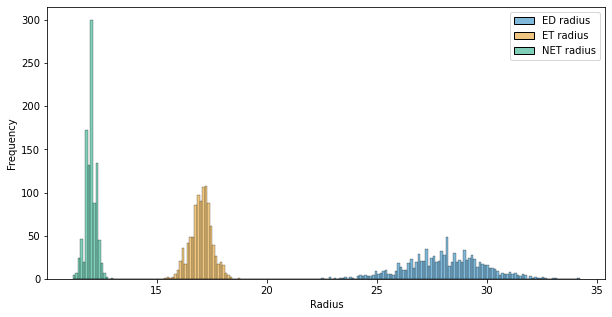

In [23]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 5)
ax = sns.histplot(data=df, bins=200, palette="colorblind")
ax.set(xlabel='Radius', ylabel='Frequency')
plt.show()

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from pathlib import Path

sample = dataset[225]

Path("visuals/overview").mkdir(parents=True, exist_ok=True)
save_image(sample["mask_circles_org"][0], fp=f"visuals/noise_r/org.png")
save_image(sample["mask_circles"][0], fp=f"visuals/noise_r/noisy.png")


fig = plt.figure(figsize=(15, 15))
i = 1
for k, v in [
    ("mask_circles", sample["mask_circles"]),
    ("mask_circles_org", sample["mask_circles_org"]),
]:
    ax = fig.add_subplot(1, 2, i)
    ax.set_title(k)
    if k in ["mask_tumor_grade"]:
        ax.imshow(np.squeeze(v), cmap="gray", vmax=3, vmin=0)
    else:
        ax.imshow(np.squeeze(v), cmap="gray", vmax=1, vmin=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    i += 1


FileNotFoundError: [Errno 2] No such file or directory: 'visuals/noise_r/org.png'

26.032806348325696 16.44330154212029 11.770090562401538
28.02978397720748 17.023775057179655 12.024391346806144


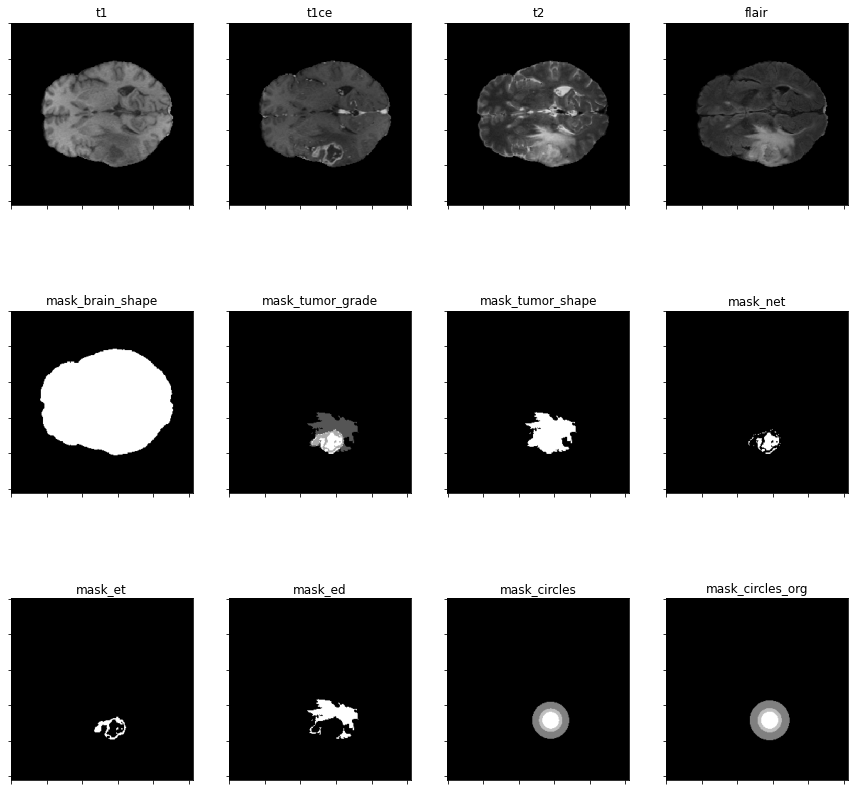

In [233]:
import matplotlib.pyplot as plt
import numpy as np

sample = dataset[710]

for array in [sample["mask_circles"],sample["mask_circles_org"]]:
    [c, h, w] = array.shape
    nonzero_idx = np.where(array > 0)
    a_whole = np.array(nonzero_idx).shape[1]

    a_ed = np.array(np.where(array >= 0.5)).shape[1]
    radius_ed = max((a_ed / 3.14) ** (0.5),0)
    a_et = np.array(np.where(array >= 0.75)).shape[1]
    radius_et = max((a_et / 3.14) ** (0.5),0)
    a_net = np.array(np.where(array >= 1.0)).shape[1]
    radius_net = max((a_net / 3.14) ** (0.5),0)

    print(radius_ed,radius_et,radius_net)

fig = plt.figure(figsize=(15, 15))

iter_n = 1
for k, v in sample.items():
    ax = fig.add_subplot(3, 4, iter_n)
    ax.set_title(k)
    if k in ["mask_tumor_grade"]:
        ax.imshow(np.squeeze(v), cmap="gray", vmax=3, vmin=0)
    else:
        ax.imshow(np.squeeze(v), cmap="gray", vmax=1, vmin=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    iter_n += 1